#Imports

In [9]:
from typing import List
import base64

#Definição das Tabelas de Substituição

In [10]:
s_box_string = '63 7c 77 7b f2 6b 6f c5 30 01 67 2b fe d7 ab 76' \
               'ca 82 c9 7d fa 59 47 f0 ad d4 a2 af 9c a4 72 c0' \
               'b7 fd 93 26 36 3f f7 cc 34 a5 e5 f1 71 d8 31 15' \
               '04 c7 23 c3 18 96 05 9a 07 12 80 e2 eb 27 b2 75' \
               '09 83 2c 1a 1b 6e 5a a0 52 3b d6 b3 29 e3 2f 84' \
               '53 d1 00 ed 20 fc b1 5b 6a cb be 39 4a 4c 58 cf' \
               'd0 ef aa fb 43 4d 33 85 45 f9 02 7f 50 3c 9f a8' \
               '51 a3 40 8f 92 9d 38 f5 bc b6 da 21 10 ff f3 d2' \
               'cd 0c 13 ec 5f 97 44 17 c4 a7 7e 3d 64 5d 19 73' \
               '60 81 4f dc 22 2a 90 88 46 ee b8 14 de 5e 0b db' \
               'e0 32 3a 0a 49 06 24 5c c2 d3 ac 62 91 95 e4 79' \
               'e7 c8 37 6d 8d d5 4e a9 6c 56 f4 ea 65 7a ae 08' \
               'ba 78 25 2e 1c a6 b4 c6 e8 dd 74 1f 4b bd 8b 8a' \
               '70 3e b5 66 48 03 f6 0e 61 35 57 b9 86 c1 1d 9e' \
               'e1 f8 98 11 69 d9 8e 94 9b 1e 87 e9 ce 55 28 df' \
               '8c a1 89 0d bf e6 42 68 41 99 2d 0f b0 54 bb 16'.replace(" ", "")

s_box = bytearray.fromhex(s_box_string)


inv_s_box_string = '52 09 6a d5 30 36 a5 38 bf 40 a3 9e 81 f3 d7 fb' \
                   '7c e3 39 82 9b 2f ff 87 34 8e 43 44 c4 de e9 cb' \
                   '54 7b 94 32 a6 c2 23 3d ee 4c 95 0b 42 fa c3 4e' \
                   '08 2e a1 66 28 d9 24 b2 76 5b a2 49 6d 8b d1 25' \
                   '72 f8 f6 64 86 68 98 16 d4 a4 5c cc 5d 65 b6 92' \
                   '6c 70 48 50 fd ed b9 da 5e 15 46 57 a7 8d 9d 84' \
                   '90 d8 ab 00 8c bc d3 0a f7 e4 58 05 b8 b3 45 06' \
                   'd0 2c 1e 8f ca 3f 0f 02 c1 af bd 03 01 13 8a 6b' \
                   '3a 91 11 41 4f 67 dc ea 97 f2 cf ce f0 b4 e6 73' \
                   '96 ac 74 22 e7 ad 35 85 e2 f9 37 e8 1c 75 df 6e' \
                   '47 f1 1a 71 1d 29 c5 89 6f b7 62 0e aa 18 be 1b' \
                   'fc 56 3e 4b c6 d2 79 20 9a db c0 fe 78 cd 5a f4' \
                   '1f dd a8 33 88 07 c7 31 b1 12 10 59 27 80 ec 5f' \
                   '60 51 7f a9 19 b5 4a 0d 2d e5 7a 9f 93 c9 9c ef' \
                   'a0 e0 3b 4d ae 2a f5 b0 c8 eb bb 3c 83 53 99 61' \
                   '17 2b 04 7e ba 77 d6 26 e1 69 14 63 55 21 0c 7d'.replace(" ", "")

inv_s_box = bytearray.fromhex(inv_s_box_string)

#Funções

##Funções Gerais

In [11]:
def add_round_key(state: List[List[int]], key_schedule: List[List[List[int]]], round: int):
    """
    No AES, a operação de adição da chave envolve a aplicação de uma operação XOR
    entre o estado atual e a chave da rodada correspondente.

    Parâmetros:
        state (List[List[int]]): Uma matriz 4xN representando o estado atual da matriz durante o processo de
                                 criptografia ou descriptografia. Cada elemento é um inteiro que representa um byte.
        key_schedule (List[List[List[int]]]): Uma lista tridimensional onde cada elemento é uma matriz 4x4 que
                                              representa uma chave expandida para uma rodada específica. Cada
                                              sub-lista contém quatro palavras de 4 bytes.
        round (int): O número da rodada atual. Este valor determina qual chave da rodada será utilizada
                     na operação de XOR com o estado.
    """
    round_key = key_schedule[round] #Pega a chave da rodada
    for r in range(len(state)):
        #Faz o xor entre o estado atual e a chave de rodada
        state[r] = [state[r][c] ^ round_key[r][c] for c in range(len(state[0]))]


def bytes_from_state(state: List[List[int]]) -> bytes:
    """
    Converte uma matriz de estado AES (Advanced Encryption Standard) em uma sequência de bytes.

    Parâmetros:
        state (List[List[int]]): Uma matriz de 4x4 inteiros, onde cada sublista representa uma coluna
                                 da matriz de estado. Cada elemento da matriz deve estar no intervalo
                                 [0, 255] e representar um byte.

    Retorna:
        bytes: Uma sequência de bytes obtida concatenando todos os bytes da matriz de estado. A sequência
               resultante terá 16 bytes (ou 128 bits) de comprimento, correspondente a uma matriz de estado
               de 4x4 bytes.
    """
    return bytes(state[0] + state[1] + state[2] + state[3])

def pad(data, block_size):
    pad_len = block_size - len(data) % block_size
    return data + bytes([pad_len] * pad_len)

def unpad(data):
    pad_len = data[-1]
    return data[:-pad_len]

def encryption(plaintext: str, key: str) -> bytes:
    plaintext_hex = plaintext.encode().hex()
    plaintext_bytes = bytearray.fromhex(plaintext_hex)

    key = bytearray.fromhex(key)
    block_size = 16

    padded_plaintext = pad(plaintext_bytes, block_size)

    ciphertext_blocks = []
    for i in range(0, len(padded_plaintext), block_size):
        block = padded_plaintext[i:i + block_size]
        ciphertext_blocks.append(aes_encryption(block, key))

    ciphertext = b''.join(ciphertext_blocks)

    return ciphertext



def decryption(ciphertext: bytes, key: str) -> str:
    key = bytearray.fromhex(key)
    block_size = 16

    decrypted_blocks = []
    for i in range(0, len(ciphertext), block_size):
        block = ciphertext[i:i + block_size]
        decrypted_blocks.append(aes_decryption(block, key))

    recovered_padded_plaintext = b''.join(decrypted_blocks)

    recovered_plaintext = unpad(recovered_padded_plaintext)

    recovered_text = recovered_plaintext.decode('utf-8')

    return recovered_text

##Funções para Expansão de chave

In [12]:
def rcon(i: int) -> bytes:
    """
    Gera um valor de constante de rodada (Rcon).

    A tabela Rcon é uma sequência predefinida de valores hexadecimais que são
    usados para criar o valor Rcon apropriado baseado no índice fornecido.

    Parâmetros:
        i (int): O índice (1 a 10 para AES-128, 1 a 12 para AES-192, e 1 a 14 para AES-256)
                 para o qual o valor Rcon deve ser gerado. O índice deve ser um número
                 inteiro positivo.

    Retorna:
        bytes: Um objeto `bytes` contendo o valor Rcon gerado. O valor retornado é
               um array de 4 bytes, onde o primeiro byte é o valor Rcon derivado, e
               os demais bytes são zero.

    Exemplo:
    >>> rcon(10)
    b'\x36\x00\x00\x00'
    """
    rcon_lookup = bytearray.fromhex('01020408102040801b36')
    rcon_value = bytes([rcon_lookup[i-1], 0, 0, 0])

    return rcon_value

def xor_bytes(a: bytes, b: bytes) -> bytes:
    """
    Esta função aplica a operação XOR (exclusive OR) entre dois arrays de bytes
    do mesmo comprimento. A operação XOR é realizada em cada byte correspondente
    das duas entradas e o resultado é retornado como um novo array de bytes.

    Parâmetros:
        a (bytes): O primeiro array de bytes para a operação XOR. Deve ter o mesmo
                   comprimento que o segundo array.
        b (bytes): O segundo array de bytes para a operação XOR. Deve ter o mesmo
                   comprimento que o primeiro array.

    Retorna:
        bytes: Um novo objeto `bytes` contendo o resultado da operação XOR bit a bit
               entre os arrays de bytes fornecidos.
    """
    return bytes([x ^ y for (x, y) in zip(a, b)])


def rot_word(word: List[int]) -> List[int]:
    """
    Esta função rotaciona uma lista de inteiros para a esquerda por uma posição.
    O primeiro elemento da lista se torna o último, e todos os outros elementos
    são deslocados uma posição à esquerda.

    Parâmetros:
        word (List[int]): A lista de inteiros a ser rotacionada. Deve conter pelo menos
                          um elemento.

    Retorna:
        List[int]: A nova lista de inteiros após a rotação. O primeiro elemento original
                   se torna o último elemento da nova lista, e os demais elementos são
                   deslocados uma posição para a esquerda.

    Exemplo:
    >>> rot_word([1, 2, 3, 4])
    [2, 3, 4, 1]
    """
    return word[1:] + word[:1]

def sub_word(word: List[int]) -> bytes:
    """
    Substitui cada byte da palavra de entrada usando a tabela S-Box.

    Parâmetros:
        word (List[int]): Uma lista de inteiros representando a palavra de entrada,
                          onde cada inteiro deve estar no intervalo de 0 a 255.

    Retorna:
        bytes: Um objeto bytes com os bytes substituídos de acordo com a tabela S-Box.
    """
    substituted_word = bytes(s_box[i] for i in word)

    #Vamos pensar que a word tem apenas uma letra, 0x53. Em decimal isso é 83
    #O índice a ser acessado na tabela é de 83
    #O valor que 83 será substituído é de 237

    return substituted_word

def key_expansion(key: bytes, nb: int = 4) -> List[List[List[int]]]:
    """
    Esta função realiza a expansão da chave inicial
    e gera uma lista de chaves de rodada, cada uma com o formato adequado para uso em uma iteração
    do algoritmo AES.

    Parâmetros:
        key (bytes): A chave inicial para expansão. Deve ter um comprimento de 16 bytes (128 bits),
                     24 bytes (192 bits) ou 32 bytes (256 bits), correspondente ao tamanho da chave AES.
        nb (int, opcional): Número de colunas no bloco de estado. O valor padrão é 4, que é utilizado
                            para blocos de 128 bits.

    Retorna:
        List[List[List[int]]]: Uma lista contendo as chaves de rodada expandidas. Cada chave de rodada é
                               uma lista de listas, onde cada lista interna representa uma coluna do bloco
                               de 4x4 (matriz de estado) de inteiros.
    """
    nk = len(key) // 4 #Número de palavras na chave inicial

    key_bit_length = len(key) * 8 #Comprimento da chave em bits

    #nr representa o número de rodadas
    if key_bit_length == 128:
        nr = 10
    elif key_bit_length == 192:
        nr = 12
    else:  # 256-bit keys
        nr = 14

    w = state_from_bytes(key) #Transforma os bytes em estados

    for i in range(nk, nb * (nr + 1)): #Vai de nk, ou seja, o final da chave, até o fim da chave expandida
        temp = w[i-1]

        if i % nk == 0: #A cada nk palavras, uma operação a mais é realizada na chave
            xor_1 = sub_word(rot_word(temp)) #Palavra da chave é rotacionada e substituido seus bytes da tabela
            xor_2 = rcon(i // nk) #Novo valor de rodada
            temp = xor_bytes(xor_1,xor_2)  #Operação de xor na palavra da chave modificada e no valor de rodada

        #As chaves de 192 bits e 256 bits precisam de uma substituição adicional a cada 4 palavras
        #Isso em teoria gera mais segurança
        elif nk > 6 and i % nk == 4:
            temp = sub_word(temp)

        w.append(xor_bytes(w[i - nk], temp)) #Novo estado é adicionado

    #Transforma em uma chave válida (do mesmo estilo dos estados)
    return [w[i*4:(i+1)*4] for i in range(len(w) // 4)]

##Funções para Criptografia

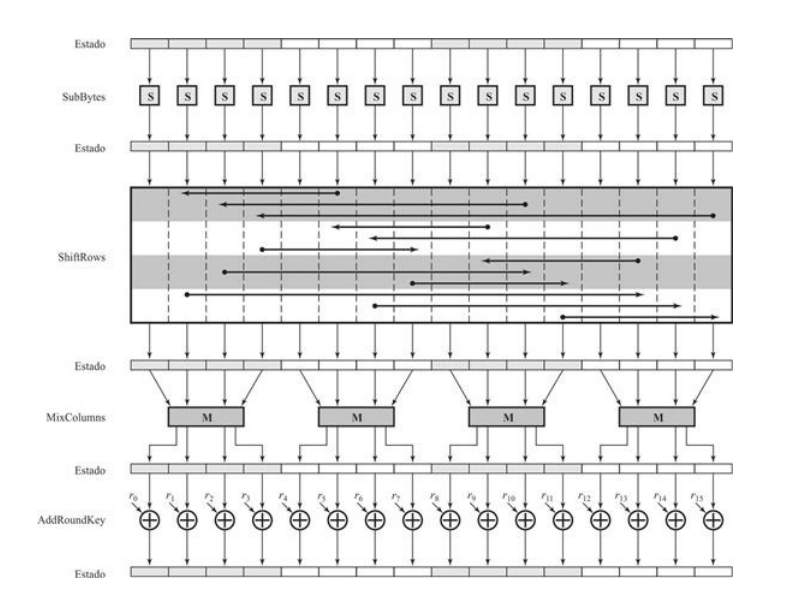

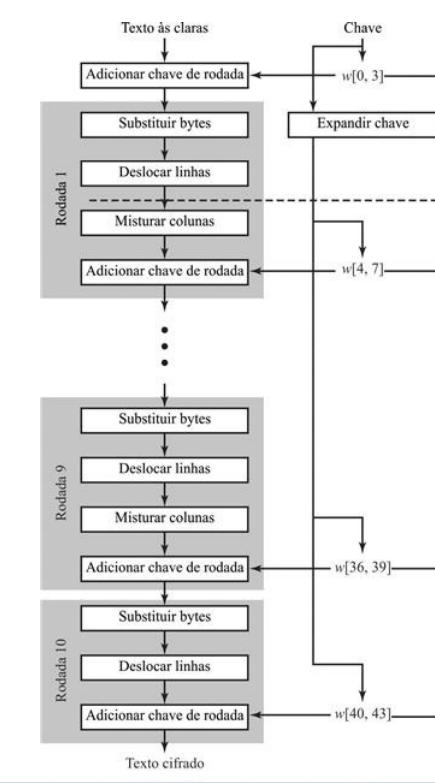

In [13]:
def sub_bytes(state: List[List[int]]):
    """
    A operação SubBytes é uma etapa do algoritmo de criptografia AES, onde cada byte do estado é substituído
    por outro byte de acordo com a tabela de substituição S-box. Esta substituição é feita para adicionar
    confusão ao processo de criptografia

    Parâmetros:
        state (List[List[int]]): Uma matriz 4xN representando o estado do AES, onde cada elemento é um byte
                                 (valor inteiro entre 0 e 255). A matriz é organizada em linhas e colunas.
    """
    for r in range(len(state)):
        #Pega o estado e substitui usando a tabela de sbox
        state[r] = [s_box[state[r][c]] for c in range(len(state[0]))]

def shift_rows(state: List[List[int]]):
    """
    A operação ShiftRows é uma etapa do algoritmo de criptografia AES que realiza um deslocamento cíclico das
    linhas da matriz de estado

    O deslocamento é feito conforme as regras abaixo:
    - A primeira linha permanece inalterada.
    - A segunda linha é deslocada uma posição para a esquerda.
    - A terceira linha é deslocada duas posições para a esquerda.
    - A quarta linha é deslocada três posições para a esquerda.

    Parâmetros:
        state (List[List[int]]): Uma matriz 4xN representando o estado do AES, onde cada elemento é um byte
                                 (valor inteiro entre 0 e 255). A matriz é organizada em linhas e colunas.
    """
    # [00, 10, 20, 30]     [00, 10, 20, 30]
    # [01, 11, 21, 31] --> [11, 21, 31, 01]
    # [02, 12, 22, 32]     [22, 32, 02, 12]
    # [03, 13, 23, 33]     [33, 03, 13, 23]
    state[0][1], state[1][1], state[2][1], state[3][1] = state[1][1], state[2][1], state[3][1], state[0][1]
    state[0][2], state[1][2], state[2][2], state[3][2] = state[2][2], state[3][2], state[0][2], state[1][2]
    state[0][3], state[1][3], state[2][3], state[3][3] = state[3][3], state[0][3], state[1][3], state[2][3]


def xtime(a: int) -> int:
    """
    Multiplica um byte (valor inteiro entre 0 e 255) por 2 no campo de polinômios Galois.

    A operação é usada para realizar uma multiplicação
    no campo de Galois (GF(2^8)). A multiplicação por 2 é realizada de forma eficiente utilizando operações de
    deslocamento e XOR.

    A função aplica a multiplicação por 2 em um byte, considerando o polinômio irreducível usado no AES (0x1b)
    para garantir que o resultado permaneça dentro do campo de Galois de 8 bits.

    Parâmetros:
        a (int): O byte a ser multiplicado por 2. Deve ser um valor inteiro entre 0 e 255 (inclusive).

    Retorna:
        int: O resultado da multiplicação por 2, que é um valor inteiro entre 0 e 255 (inclusive).
    """
    if a & 0x80: #Verifica se o bit mais significativo está definido
        return ((a << 1) ^ 0x1b) & 0xff #Faz o deslocamento mas de forma diferente
    return a << 1 #Deslocamento a esquerda


def mix_column(col: List[int]):
    """
    Aplica a transformação de MixColumns em uma coluna de uma matriz de estado AES.

    A operação MixColumns usa um polinômio irreducível para misturar os bytes em cada coluna
    da matriz de estado. A função `xtime` é utilizada para realizar multiplicação por 2 no
    campo GF(2^8), e a operação XOR é usada para combinar os valores.

    Parâmetros:
        col (List[int]): Uma lista de 4 inteiros que representam uma coluna da matriz de estado.
                         Cada inteiro deve estar no intervalo [0, 255] e representa um byte.

    Retorna:
        None: A função modifica a lista `col` no local (in-place), atualizando os valores
              da coluna com os resultados da transformação MixColumns.
    """
    c_0 = col[0] #A coluna 0 inicialmente (será usada depois)

    all_xor = col[0] ^ col[1] ^ col[2] ^ col[3] #Xor entre todas as 4 colunas de estado
    col[0] ^= all_xor ^ xtime(col[0] ^ col[1])
    col[1] ^= all_xor ^ xtime(col[1] ^ col[2])
    col[2] ^= all_xor ^ xtime(col[2] ^ col[3])
    col[3] ^= all_xor ^ xtime(c_0 ^ col[3])


def mix_columns(state: List[List[int]]):
    """
    Aplica a transformação de MixColumns em todas as colunas de uma matriz de estado AES.

    Parâmetros:
        state (List[List[int]]): Uma matriz de 4x4 inteiros, onde cada sublista representa uma coluna
                                 da matriz de estado. Cada elemento da matriz deve estar no intervalo
                                 [0, 255] e representar um byte.

    Retorna:
        None: A função modifica a matriz `state` no local (in-place), atualizando cada coluna com
              os resultados da transformação MixColumns.
    """
    for r in state:
        mix_column(r)

def state_from_bytes(data: bytes) -> List[List[int]]:
    """
    O AES trabalha com dados em uma matriz de estado de 4 linhas por 4 colunas, onde cada elemento da matriz é um byte.
    Esta função pega uma sequência de bytes e a organiza em uma matriz de estado conforme exigido pelo algoritmo AES.

    Parâmetros:
        data (bytes): Uma sequência de bytes com comprimento que deve ser um múltiplo de 16 (por exemplo, 16, 32, 48, etc.).
                      Representa os dados a serem convertidos para a estrutura de estado.

    Retorna:
        List[List[int]]: Uma lista de listas representando a matriz de estado 4x4. Cada sublista contém 4 inteiros que
                         correspondem aos bytes extraídos da sequência de bytes de entrada. A matriz resultante é usada
                         no processo de criptografia e descriptografia do AES.

    """
    #Extrai um bloco de 4 bytes e adiciona no fim da lista a cada iteração
    state = [data[i*4:(i+1)*4] for i in range(len(data) // 4)]
    return state

def aes_encryption(data: bytes, key: bytes) -> bytes:
    """
    A função `aes_encryption` implementa o algoritmo de criptografia AES com suporte para chaves de 128, 192 e 256 bits.
    Ela realiza a criptografia de uma sequência de bytes (`data`) usando uma chave de criptografia (`key`) e retorna
    o texto cifrado correspondente.

    Parâmetros:
        data (bytes): A sequência de bytes a ser criptografada. Deve ter exatamente 16 bytes (128 bits) para
                      chaves de 128 bits, ou o tamanho adequado para chaves de 192 ou 256 bits.
        key (bytes): A chave de criptografia para o algoritmo AES. Deve ter 16 bytes (128 bits) para chaves de 128 bits,
                     24 bytes (192 bits) para chaves de 192 bits, ou 32 bytes (256 bits) para chaves de 256 bits.

    Retorna:
        bytes: A sequência de bytes cifrada resultante da criptografia AES. A saída terá o mesmo comprimento de entrada
               (16 bytes) para uma matriz de estado de 128 bits.
    """
    key_bit_length = len(key) * 8

    #Define a quantidade de rodadas que serão necessárias
    if key_bit_length == 128:
        nr = 10
    elif key_bit_length == 192:
        nr = 12
    else:
        nr = 14

    state = state_from_bytes(data) #Pega os estados

    key_schedule = key_expansion(key) #Expande a chave

    add_round_key(state, key_schedule, round=0) #Adiciona a chave de rodada ao estado atual

    #Note que semanticamente esse loop começa na rodada 0, apesar da variável round começar
    #em 1 (para o add_round_key final dar certo)
    for round in range(1, nr): #A cada uma das rodadas
        sub_bytes(state) #Substitui os bytes
        shift_rows(state) #Desloca as linhas
        mix_columns(state) #Mistura as colunas
        add_round_key(state, key_schedule, round) #Adiciona a chave de rodada ao estado atual

    sub_bytes(state) #Substitui os bytes da última rodada
    shift_rows(state) #Desloca as linhas da última rodada
    add_round_key(state, key_schedule, round=nr) #Adiciona a chave de rodada ao estado atual na última rodada

    cipher = bytes_from_state(state) #Cifra
    return cipher

##Funções para Decriptografia

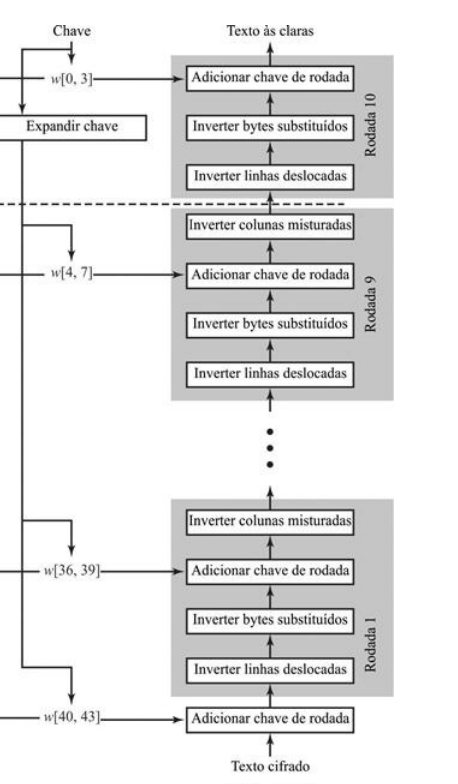

In [14]:
def inv_shift_rows(state: List[List[int]]) -> List[List[int]]:
    """
    A operação de inversão de permutação de linhas é uma das etapas do processo de descriptografia no algoritmo AES.
    Ela reverte a rotação das linhas realizada na etapa de permutação de linhas durante a criptografia.

    Parâmetros:
        state (List[List[int]]): A matriz de estado (4x4) representada como uma lista de listas de inteiros.
                                 Cada sublista representa uma coluna de 4 bytes (0-255).
    """
    # [00, 10, 20, 30]     [00, 10, 20, 30]
    # [01, 11, 21, 31] <-- [11, 21, 31, 01]
    # [02, 12, 22, 32]     [22, 32, 02, 12]
    # [03, 13, 23, 33]     [33, 03, 13, 23]
    #Se comparado com a shift rows, verá que é literalmente o inverso
    state[1][1], state[2][1], state[3][1], state[0][1] = state[0][1], state[1][1], state[2][1], state[3][1]
    state[2][2], state[3][2], state[0][2], state[1][2] = state[0][2], state[1][2], state[2][2], state[3][2]
    state[3][3], state[0][3], state[1][3], state[2][3] = state[0][3], state[1][3], state[2][3], state[3][3]
    return


def inv_sub_bytes(state: List[List[int]]) -> List[List[int]]:
    """
    A operação de inversão da substituição de bytes é uma das etapas do processo de descriptografia no algoritmo AES.
    Ela reverte a substituição de bytes realizada na etapa `sub_bytes` durante a criptografia, utilizando uma tabela
    de substituição inversa (InvSBox).

    Parâmetros:
        state (List[List[int]]): A matriz de estado (4x4) representada como uma lista de listas de inteiros.
                                 Cada sublista representa uma coluna de 4 bytes (0-255).
    """
    for r in range(len(state)):
        state[r] = [inv_s_box[state[r][c]] for c in range(len(state[0]))]


def xtimes_0e(b: int) -> int:
    """
    Multiplica o byte `b` por 0x0e (14 em decimal) no campo finito GF(2^8) usando aritmética modular.

    O valor 0x0e pode ser representado como b1110 em binário, e a multiplicação é realizada por repetidas
    aplicações de deslocamento e XOR, conforme a fórmula:
    ((x * 2 + x) * 2 + x) * 2

    Parâmetros:
        b (int): O byte a ser multiplicado, representado como um inteiro de 8 bits (0-255).

    Retorna:
        int: O resultado da multiplicação de `b` por 0x0e, como um byte (0-255).
    """
    return xtime(xtime(xtime(b) ^ b) ^ b)


def xtimes_0b(b: int) -> int:
    """
    Multiplica o byte `b` por 0x0b (11 em decimal) no campo finito GF(2^8) usando aritmética modular.

    O valor 0x0b pode ser representado como b1011 em binário, e a multiplicação é realizada por repetidas
    aplicações de deslocamento e XOR, conforme a fórmula:
    ((x * 2) * 2 + x) * 2 + x

    Parâmetros:
        b (int): O byte a ser multiplicado, representado como um inteiro de 8 bits (0-255).

    Retorna:
        int: O resultado da multiplicação de `b` por 0x0b, como um byte (0-255).
    """
    return xtime(xtime(xtime(b)) ^ b) ^ b


def xtimes_0d(b: int) -> int:
    """
    Multiplica o byte `b` por 0x0d (13 em decimal) no campo finito GF(2^8) usando aritmética modular.

    O valor 0x0d pode ser representado como b1101 em binário, e a multiplicação é realizada por repetidas
    aplicações de deslocamento e XOR, conforme a fórmula:
    ((x * 2 + x) * 2) * 2 + x

    Parâmetros:
        b (int): O byte a ser multiplicado, representado como um inteiro de 8 bits (0-255).

    Retorna:
        int: O resultado da multiplicação de `b` por 0x0d, como um byte (0-255).
    """
    return xtime(xtime(xtime(b) ^ b)) ^ b


def xtimes_09(b: int) -> int:
    """
    Multiplica o byte `b` por 0x09 (9 em decimal) no campo finito GF(2^8) usando aritmética modular.

    O valor 0x09 pode ser representado como b1001 em binário, e a multiplicação é realizada por repetidas
    aplicações de deslocamento e XOR, conforme a fórmula:
    ((x * 2) * 2) * 2 + x

    Parâmetros:
        b (int): O byte a ser multiplicado, representado como um inteiro de 8 bits (0-255).

    Retorna:
        int: O resultado da multiplicação de `b` por 0x09, como um byte (0-255).
    """
    return xtime(xtime(xtime(b))) ^ b


def inv_mix_column(col: List[int]):
    """
    Aplica a operação de misturar uma coluna no estado do AES usando a matriz inversa de mistura de coluna.

    Parâmetros:
        col (List[int]): Uma lista de 4 inteiros (valores de byte) representando uma coluna no estado.

    A função atualiza a lista `col` com os novos valores após a aplicação da operação de inversão de mistura de coluna.
    """
    c_0, c_1, c_2, c_3 = col[0], col[1], col[2], col[3]
    col[0] = xtimes_0e(c_0) ^ xtimes_0b(c_1) ^ xtimes_0d(c_2) ^ xtimes_09(c_3)
    col[1] = xtimes_09(c_0) ^ xtimes_0e(c_1) ^ xtimes_0b(c_2) ^ xtimes_0d(c_3)
    col[2] = xtimes_0d(c_0) ^ xtimes_09(c_1) ^ xtimes_0e(c_2) ^ xtimes_0b(c_3)
    col[3] = xtimes_0b(c_0) ^ xtimes_0d(c_1) ^ xtimes_09(c_2) ^ xtimes_0e(c_3)


def inv_mix_columns(state: List[List[int]]) -> List[List[int]]:
    """
    Aplica a operação de inversão de mistura de colunas no estado do AES.

    Parâmetros:
        state (List[List[int]]): Uma matriz 4x4 representando o estado do AES, onde cada elemento é
                                 um byte (inteiro de 0 a 255).

    Retorna:
        List[List[int]]: O estado atualizado após a aplicação da operação de inversão de mistura de
                         coluna em cada coluna do estado.
    """
    for r in state:
        inv_mix_column(r)
    return state


def aes_decryption(cipher: bytes, key: bytes) -> bytes:
    """
    Esta função realiza a descriptografia de uma mensagem cifrada no formato AES usando a chave fornecida.
    O processo é o inverso da criptografia AES e segue os passos de inversão das operações realizadas durante
    a criptografia.

    Parâmetros:
        cipher (bytes): A mensagem cifrada (texto cifrado) a ser descriptografada. Deve estar no formato de
                        bytes e ter um tamanho adequado para o algoritmo AES.
        key (bytes): A chave usada para a descriptografia. Pode ter 16 bytes (128 bits), 24 bytes (192 bits)
                     ou 32 bytes (256 bits) de comprimento.

    Retorna:
        bytes: A mensagem descriptografada (texto em claro), retornada como uma sequência de bytes.
    """
    key_byte_length = len(key)
    key_bit_length = key_byte_length * 8
    nk = key_byte_length // 4 #Número de palavras na chave inicial

    #Definição do número de rodadas
    if key_bit_length == 128:
        nr = 10
    elif key_bit_length == 192:
        nr = 12
    else:  # 256-bit keys
        nr = 14

    state = state_from_bytes(cipher) #Pega os estados
    key_schedule = key_expansion(key) #Faz a expansão da chave
    add_round_key(state, key_schedule, round=nr) #Adiciona a chave da rodada

    for round in range(nr-1, 0, -1): #Começa da rodada final até a inicial
        inv_shift_rows(state) #Reverte o shift de linhas
        inv_sub_bytes(state) #Pega os valores inversos da tabela s
        add_round_key(state, key_schedule, round) #Adiciona a chave de rodada da próxima rodada
        inv_mix_columns(state) #Reverte a mixagem de colunas

    inv_shift_rows(state) #Reverte o shuft de linhas da última rodada
    inv_sub_bytes(state) #Pega os valores inversos da tabela s na última rodada
    add_round_key(state, key_schedule, round=0) #Adiciona a última chave de rodada

    plain = bytes_from_state(state) #Pega o texto descriptografado
    return plain

#Teste com texto às claras de 32 bytes

In [18]:
#Documento do NIST: https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.197-upd1.pdf

#NIST FIPS PUB 197 ADVANCED ENCRYPTION STANDARD (AES)

# NIST AES-128 test vector 1 (Ch. C.1, p. 35)
plaintext = bytearray.fromhex('00112233445566778899aabbccddeeff')
key = bytearray.fromhex('000102030405060708090a0b0c0d0e0f')
expected_ciphertext = bytearray.fromhex('69c4e0d86a7b0430d8cdb78070b4c55a')
ciphertext = aes_encryption(plaintext, key)
recovered_plaintext = aes_decryption(ciphertext, key)

assert (ciphertext == expected_ciphertext)
assert (recovered_plaintext == plaintext)

print(f"Texto às claras: {plaintext}")
print(f"Texto cifrado: {ciphertext}")
print(f"Texto recuperado: {recovered_plaintext}", end="\n\n")

# NIST AES-192 test vector 2 (Ch. C.2, p. 38)
plaintext = bytearray.fromhex('00112233445566778899aabbccddeeff')
key = bytearray.fromhex('000102030405060708090a0b0c0d0e0f1011121314151617')
expected_ciphertext = bytearray.fromhex('dda97ca4864cdfe06eaf70a0ec0d7191')
ciphertext = aes_encryption(plaintext, key)
recovered_plaintext = aes_decryption(ciphertext, key)

assert (ciphertext == expected_ciphertext)
assert (recovered_plaintext == plaintext)

print(f"Texto às claras: {plaintext}")
print(f"Texto cifrado: {ciphertext}")
print(f"Texto recuperado: {recovered_plaintext}", end="\n\n")


# NIST AES-256 test vector 3 (Ch. C.3, p. 42)
plaintext = bytearray.fromhex('00112233445566778899aabbccddeeff')
key = bytearray.fromhex('000102030405060708090a0b0c0d0e0f101112131415161718191a1b1c1d1e1f')
expected_ciphertext = bytearray.fromhex('8ea2b7ca516745bfeafc49904b496089')
ciphertext = aes_encryption(plaintext, key)
recovered_plaintext = aes_decryption(ciphertext, key)

assert (ciphertext == expected_ciphertext)
assert (recovered_plaintext == plaintext)

print(f"Texto às claras: {plaintext}")
print(f"Texto cifrado: {ciphertext}")
print(f"Texto recuperado: {recovered_plaintext}", end="\n\n")

Texto às claras: bytearray(b'\x00\x11"3DUfw\x88\x99\xaa\xbb\xcc\xdd\xee\xff')
Texto cifrado: b'i\xc4\xe0\xd8j{\x040\xd8\xcd\xb7\x80p\xb4\xc5Z'
Texto recuperado: b'\x00\x11"3DUfw\x88\x99\xaa\xbb\xcc\xdd\xee\xff'

Texto às claras: bytearray(b'\x00\x11"3DUfw\x88\x99\xaa\xbb\xcc\xdd\xee\xff')
Texto cifrado: b'\xdd\xa9|\xa4\x86L\xdf\xe0n\xafp\xa0\xec\rq\x91'
Texto recuperado: b'\x00\x11"3DUfw\x88\x99\xaa\xbb\xcc\xdd\xee\xff'

Texto às claras: bytearray(b'\x00\x11"3DUfw\x88\x99\xaa\xbb\xcc\xdd\xee\xff')
Texto cifrado: b'\x8e\xa2\xb7\xcaQgE\xbf\xea\xfcI\x90KI`\x89'
Texto recuperado: b'\x00\x11"3DUfw\x88\x99\xaa\xbb\xcc\xdd\xee\xff'



# Teste com Texto Real

In [19]:
texto_as_claras = "Olá meu nome é Cassiano"
key = '000102030405060708090a0b0c0d0e0f'

print(f"Texto original: {texto_as_claras}")

ciphertext = encryption(texto_as_claras, key)
print(f"Texto cifrado: {base64.b64encode(ciphertext).decode('utf-8')}", len(ciphertext))

decrypted_text = decryption(ciphertext, key)
print(f"Texto recuperado: {decrypted_text}")

Texto original: Olá meu nome é Cassiano
Texto cifrado: V6MHlPifMj3n1IZjuafqWZGUhhJTyGngI5d3roZT1vk= 32
Texto recuperado: Olá meu nome é Cassiano
